# Useful links

https://github.com/MaartenGr/BERTopic 

Starter notebook for basic BERTopic model: 
https://colab.research.google.com/drive/1FieRA9fLdkQEGDIMYl0I3MCjSUKVF8C-?usp=sharing#scrollTo=5m4Nd7Us-Peg

Choice of embedding model:
https://www.sbert.net/docs/pretrained_models.html

Hyperparameters:
https://maartengr.github.io/BERTopic/api/bertopic.html.  

https://colab.research.google.com/drive/1ClTYut039t-LDtlcd-oQAdXWgcsSGTw9?usp=sharing

Dynamic topic modelling starter notebook:
https://colab.research.google.com/drive/1un8ooI-7ZNlRoK0maVkYhmNRl0XGK88f?usp=sharing

# Setup

In [ ]:
%pip install bertopic

     |████████████████████████████████| 57 kB 2.1 MB/s 
     |████████████████████████████████| 79 kB 5.9 MB/s 
     |████████████████████████████████| 86 kB 3.9 MB/s 
     |████████████████████████████████| 5.2 MB 15.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 3.8 MB 12.6 MB/s 
     |████████████████████████████████| 1.2 MB 10.1 MB/s 
     |████████████████████████████████| 67 kB 2.5 MB/s 
     |████████████████████████████████| 895 kB 20.7 MB/s 
     |████████████████████████████████| 6.5 MB 34.2 MB/s 
     |████████████████████████████████| 636 kB 38.5 MB/s 
     |████████████████████████████████| 1.1 MB 34.0 MB/s 
  Created wheel for hdbscan: filename=hdbscan-0.8.28-cp37-cp37m-linux_x86_64.whl size=2330761 sha256=de1a5729953339f9d1e7b4c05258c690b91903b27e3c2e5fe72e624d1208a999
  Stored in directory: /root/.cache/pip/wheels/6e/7a/5e/259ccc841c085fc41b99ef

In [ ]:
### import packages
from bertopic import BERTopic
import pandas as pd   
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
import seaborn as sns
from nltk.util import ngrams
import string
import re
import datetime as dt
import numpy as np
import random
import torch
import matplotlib.pyplot as plt 
from wordcloud import WordCloud
from collections import Counter
from PIL import Image
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from typing import List
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from umap import UMAP
import plotly.graph_objs as go
import itertools
from plotly.subplots import make_subplots

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# Set directory and path
import os
from google.colab import drive
drive.mount('/content/drive')
path='/content/drive/MyDrive/Classroom/21DM007 Text Mining: Models and Algorithms 21-22 DSDM T2/textminingfinal'
os.chdir(path)
results_path='/content/drive/MyDrive/Classroom/21DM007 Text Mining: Models and Algorithms 21-22 DSDM T2/textminingfinal/Results/'

Mounted at /content/drive


In [ ]:
### Set seed for reproducibility 
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(42)
random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)

In [ ]:
#Functions
### Cleaning Function 
def cleaning(text):
    # Remove Punctuation 
    clean_text=text.translate(str.maketrans('', '', string.punctuation))
    # Remove Symbols 
    clean_text=re.sub(r'[^\w]', ' ', clean_text)
    # Remove Numbers
    clean_text=clean_text.translate(str.maketrans('', '', string.digits))
    # Put in Lowercase 
    clean_text=clean_text.lower()
    # Remove StopWords
    var=clean_text.split()
    filtered_list=[]
    for word in var:
        if word not in stop_words:
           filtered_list.append(word)
    clean_text=" ".join(map(str, filtered_list))
    return clean_text

def lemmatizing(text):
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in text.split()])
    return lemmatized_output 

### Get the number of each representative word on the most representative topic  
def get_word_count_by_document(text,topic,dict_topics):
  new_dict={}
  for i in dict(dict_topics[topic]).keys(): 
    new_dict[i]=text.count(i)
  return new_dict

def get_word_proportion_by_document(text,topic,dict_topics):
  new_dict={}
  for i in dict(dict_topics[topic]).keys(): 
    new_dict[i]=(text.count(i)/len(text))
  return new_dict



# Read and clean data

In [ ]:
# Read Dataset
data=pd.read_csv(path+'/csv files/full_data_clean.csv',sep='|')

In [ ]:
# Global Variables 
# stop words
stop_words = set(stopwords.words('english'))
# lemmatizer
lemmatizer = WordNetLemmatizer()

In [ ]:
# Tokenize Corpus 
data['tokens']=[nltk.word_tokenize(i) for i in data['summary']]
data['len_corpus']=[len(i) for i in data['tokens']]

In [ ]:
#clean and lemmatize
data['clean_text']=[cleaning(i) for i in data['summary']]
data['lem_text']=[lemmatizing(i) for i in data['clean_text']]

In [ ]:
#fix date
data = data[data['publication_date'].notna()]
data['publication_date'] = pd.to_datetime(data['publication_date'], format = "%B %d, %Y")

## Exploratory Visualization 

In [ ]:
### Visualization 
## The tokenization here is just for visualization not for BERT Preprocesing
# Tokenize Corpus 
data['tokens']=[nltk.word_tokenize(i) for i in data['summary']]
data['len_corpus']=[len(i) for i in data['tokens']]


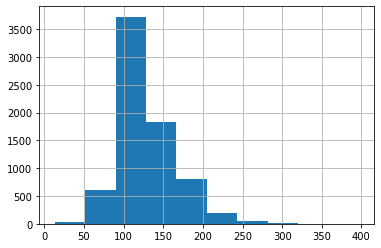

In [ ]:
# Visualization of word length
data['len_corpus'].hist()
plt.show()

In [ ]:
# Vectorize with ngrams
vectorizer = CountVectorizer(ngram_range=(1,2),max_df=0.025)
# Works with sparse matrix is really fast in comparison with dataframes
X = vectorizer.fit_transform(data['lem_text'])
# Converting to TM-IDF
tfidf=TfidfTransformer()
Z=tfidf.fit_transform(X)
l=Z.T.sum(axis=1)
new_data = pd.DataFrame(l.T,columns=vectorizer.get_feature_names())
new_data=new_data.to_dict('records')[0]

In [ ]:
# The mask put the shape of the IMF, remember to upload the image in the git repository to drive
mask = np.array(Image.open(path+"/assets/Diapositiva1.png"))
cloud = WordCloud(mask=mask,max_words=100,width = 3000, height = 2000, random_state=1, background_color='black', colormap='Set2', collocations=False).generate_from_frequencies(new_data)

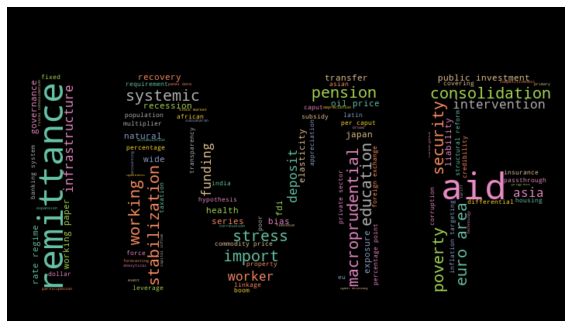

In [ ]:
fig=plt.figure(figsize=[10,10])
plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")
plt.savefig(results_path+'/word_cloud.png')
plt.show()


# Initial BERT Topic model

In [ ]:
### Set seed for reproducibility 
umap_model = UMAP(n_neighbors=15, n_components=5, 
                  min_dist=0.0, metric='cosine', random_state=42)

In [ ]:
# BERT Topic Modeling

topic_model = BERTopic(embedding_model = 'all-mpnet-base-v2', language="english", 
                       calculate_probabilities=True, verbose=True,
                       top_n_words = 10, n_gram_range = (1,2),
                       min_topic_size = 20, vectorizer_model = None,
                       umap_model = umap_model)

topics, probs = topic_model.fit_transform(data['lem_text'].to_list())

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/227 [00:00<?, ?it/s]

2022-03-28 20:09:16,355 - BERTopic - Transformed documents to Embeddings
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
2022-03-28 20:10:02,419 - BERTopic - Reduced dimensionality with UMAP
2022-03-28 20:10:04,508 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [ ]:
data.head()

,title,authors,publication_date,summary,length,subjects,url,tokens,len_corpus,clean_text,lem_text
0,Secular Drivers of the Natural Rate of Interes...,Josef Platzer ; Marcel Peruffo,2022-02-11,"We develop a heterogeneous agent, overlapping ...",88.0,NaN,https://www.imf.org/en/Publications/WP/Issues/...,"[We, develop, a, heterogeneous, agent, ,, over...",253,develop heterogeneous agent overlapping genera...,develop heterogeneous agent overlapping genera...
1,2020 Global Stocktaking of National Accounts S...,Anthony Silungwe ; Andrew Baer ; Vanda Guerreiro,2022-02-11,"This paper analyzes the availability, methodol...",26.0,NaN,https://www.imf.org/en/Publications/WP/Issues/...,"[This, paper, analyzes, the, availability, ,, ...",238,paper analyzes availability methodological sou...,paper analyzes availability methodological sou...
2,"Dollar Invoicing, Global Value Chains, and the...",David Cook ; Nikhil Patel,2022-02-11,Recent literature has highlighted that interna...,46.0,NaN,https://www.imf.org/en/Publications/WP/Issues/...,"[Recent, literature, has, highlighted, that, i...",183,recent literature highlighted international tr...,recent literature highlighted international tr...
3,Falling Use of Cash and Demand for Retail Cent...,Tanai Khiaonarong ; David Humphrey,2022-02-04,Cash use in most countries is falling slowly. ...,25.0,NaN,https://www.imf.org/en/Publications/WP/Issues/...,"[Cash, use, in, most, countries, is, falling, ...",113,cash use countries falling slowly margin young...,cash use country falling slowly margin younger...
4,Gendered Taxes: The Interaction of Tax Policy ...,Maria Delgado Coelho ; Aieshwarya Davis ; Alex...,2022-02-04,This paper provides an overview of the relatio...,53.0,NaN,https://www.imf.org/en/Publications/WP/Issues/...,"[This, paper, provides, an, overview, of, the,...",158,paper provides overview relation tax policy ge...,paper provides overview relation tax policy ge...


In [ ]:
# Get topics and its words
dict_topics=topic_model.get_topics()
# Saving usefull columns on the dataframe 
data['topic_text']=topics
data['probs_text']=[i for i in probs]
data['max_prob']=[max(i) for i in data['probs_text']]
data['count_words']=[get_word_count_by_document(i,j,dict_topics) for i,j in zip(data['lem_text'],data['topic_text'])]
data['tf_words']=[get_word_proportion_by_document(i,j,dict_topics) for i,j in zip(data['lem_text'],data['topic_text'])]
data['words_topic']=[[j[0] for j in dict_topics.get(i)] for i in data['topic_text']]

In [ ]:
#see all topics and associated c-TF-IDF score
topic_model.get_topics()

{-1: [('financial', 0.007893022217355551),
  ('policy', 0.00781002537995849),
  ('paper', 0.007604439607627114),
  ('bank', 0.007108170213733693),
  ('rate', 0.006908558535247821),
  ('market', 0.006516937846240547),
  ('country', 0.006432844717601684),
  ('monetary', 0.005985974757071166),
  ('model', 0.005812900036980014),
  ('growth', 0.0058070011448361795)],
 0: [('exchange', 0.042921141297771304),
  ('exchange rate', 0.03993679533270547),
  ('rate', 0.03254603394118333),
  ('real exchange', 0.015717052545985766),
  ('real', 0.015481013278658263),
  ('regime', 0.014215745005297927),
  ('currency', 0.01055462376872734),
  ('intervention', 0.009415560177129034),
  ('foreign', 0.009000686100630786),
  ('market', 0.00887368258341357)],
 1: [('inflation', 0.04998168193667716),
  ('monetary', 0.01973244962655443),
  ('monetary policy', 0.01607720798038442),
  ('policy', 0.015382275431974277),
  ('targeting', 0.014432079807821893),
  ('rate', 0.01339101527370889),
  ('inflation targeting'

In [ ]:
#extract the most frequent topics
freq = topic_model.get_topic_info()
freq_resum=freq.head(10)

#Save the table on HTML with jupyter format
dphtml = r'<link rel="stylesheet" href="https://cdn.jupyter.org/notebook/5.1.0/style/style.min.css">' + '\n'
dphtml = r'<link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.3.2/css/bootstrap.min.css">'+ '\n'
dphtml += freq_resum.to_html(classes='table table-striped table-fit', justify='left',index=False)
with open(results_path+'/top_10_topics_table.html','w') as f:
    f.write(dphtml)

freq_resum



,Topic,Count,Name
0,-1,2670,-1_financial_policy_paper_bank
1,0,328,0_exchange_exchange rate_rate_real exchange
2,1,296,1_inflation_monetary_monetary policy_policy
3,2,246,2_tax_revenue_vat_income
4,3,237,3_debt_sovereign_bond_spread
5,4,235,4_fiscal_fiscal policy_consolidation_rule
6,5,215,5_wage_labor_unemployment_labor market
7,6,153,6_inequality_income_poverty_education
8,7,123,7_shock_cycle_business cycle_business
9,8,110,8_climate_subsidy_emission_carbon


-1 refers to all outliers and should typically be ignored. Next, let's take a look at the most frequent topic that was generated.

In [ ]:
# Get the most representative words and score for a specific topic
topic_model.get_topic(0)

[('exchange', 0.042921141297771304),
 ('exchange rate', 0.03993679533270547),
 ('rate', 0.03254603394118333),
 ('real exchange', 0.015717052545985766),
 ('real', 0.015481013278658263),
 ('regime', 0.014215745005297927),
 ('currency', 0.01055462376872734),
 ('intervention', 0.009415560177129034),
 ('foreign', 0.009000686100630786),
 ('market', 0.00887368258341357)]

In [ ]:
# Get the most representative documents for a specific topic
topic_model.get_representative_docs(topic=0)

['paper examines behavior daily spot exchange rate sample industrialized country generally considered floating occasional official foreign exchange market intervention behavior compared behavior exchange rate sample sixteen developing country whose regime often classified flexible considerable difference way developing country exchange rate regime operate apparent daily data sharing similarity regime industrialized country others demonstrating regime shift marked discontinuity',
 'increased attention paid assessment actual value country real exchange rate relative equilibrium value suggested fundamental determining factor paper ass robustness alternative approach model commonly used derive equilibrium real exchange rate estimate using china currency illustrate analysis variance estimate raise serious question regarding robust result basic conclusion test used least china small change model specification explanatory variable definition time period used estimation lead substantial differ

In [ ]:
#get number of topics. Minus 1 because the set of topics includes (-1)
number_of_topics = len(set(topics)) - 1
number_of_topics

66

## Dynamic Topic Model

In [ ]:
# Format the date to fit the expected by BERT
timestamps = data['publication_date']
docs = [str(i) for i in data['lem_text']]

## 10 bins

In [ ]:
# Visualization with 10 Bins
topics_over_time = topic_model.topics_over_time(docs=docs, 
                                                topics=topics, 
                                                timestamps=timestamps, 
                                                global_tuning=True, 
                                                evolution_tuning=True, 
                                                nr_bins=10)

10it [00:41,  4.14s/it]


In [ ]:
# Line plot of the evolution of the topics
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=10, normalize_frequency = False)

## 10 Bins Over Specific Topics

In [ ]:
# Specific topics we want to visualize 
big_topics={'Exchange rates and monetary policy':[0, 1, 3, 14, 16, 43, 58],'Fiscal policy and commodity exporters':[2, 3, 4, 9, 25],'Current account and capital flows':[19, 45, 48, 39],'Contemporary issues':[6, 8, 22, 32, 59],'Aid, remittances, IMF assistance':[11, 15, 24, 28]}
for i,j in big_topics.items():
  sepcific=topic_model.visualize_topics_over_time(topics_over_time, topics=j, normalize_frequency = False)
  sepcific.write_html(results_path + i+'.html')
  

## 6 bins

In [ ]:
# Visualization with 6 Bins
topics_over_time = topic_model.topics_over_time(docs=docs, 
                                                topics=topics, 
                                                timestamps=timestamps, 
                                                global_tuning=True, 
                                                evolution_tuning=True, 
                                                nr_bins=6)

6it [00:30,  5.02s/it]


In [ ]:
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=66, normalize_frequency = False)

In [ ]:
#visualise dynamic topic model for top 20 topics
dynamic_vis_br=topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=66, normalize_frequency = False)
dynamic_vis_br.write_html(results_path + 'All_Topics_Over_Time_BR.html')

# Visualise topics

In [ ]:
#visualise topics
topic_model.visualize_topics()

In [ ]:
#visualise topics
vis=topic_model.visualize_topics()
vis.write_html(results_path + 'no_reduction_intertopic.html')

In [ ]:
#viualise topic probabilities for a given article
article = 5
print('Topic probability distribution for', data.loc[article, 'title'])
topic_model.visualize_distribution(probs[article], min_probability=0.02)
#object.write_html(figure_save_path + 'no_reduction_covid_article_probabilities.html')

Topic probability distribution for Loss-of-Learning and the Post-Covid Recovery in Low-Income Countries


In [ ]:
#visualise hierarchy
topic_model.visualize_hierarchy(top_n_topics=50)

In [ ]:
#visualise terms for top topics
topic_model.visualize_barchart(top_n_topics=20)

In [ ]:
# Save top words by topic before the reduction
top_words_before_red_20=topic_model.visualize_barchart(top_n_topics=20)
top_words_before_red_20.write_html(results_path + 'Top_Words_BR_20.html')

In [ ]:
#get similairy score for array. This will help to justify choice of similarity score parameter. 
no_reduction_similarities = topic_model.visualize_heatmap(n_clusters=20, width=1000, height=1000).data[0]
#visualise similarity
topic_model.visualize_heatmap(n_clusters=20, width=1000, height=1000)

In [ ]:
matrix_vis=topic_model.visualize_heatmap(n_clusters=20, width=1000, height=1000)

In [ ]:
#visualise term score decline - explanation below taken directly from BERTopic example code
topic_model.visualize_term_rank(topics=list(range(0,20)))

In [ ]:
# Save the term score
term_vis=topic_model.visualize_term_rank(topics=list(range(0,20)))
term_vis.write_html(results_path + 'Term_Score.html')

# MMR

In [ ]:
# get document embeddings
def doc_embedings(topic):
  data_topic=data[data['topic_text']==topic].reset_index()
  embedding_model = SentenceTransformer('all-mpnet-base-v2')
  document_embeddings = embedding_model.encode([data_topic['lem_text']], show_progress_bar = True)
  return document_embeddings

In [ ]:
# get words by topic
def get_topic_words(chosen_topic):
  words=[]
  for i in topic_model.get_topic(chosen_topic):
    words.append(i[0]) 
  return words

In [ ]:
# get word embeding
def word_embeding(words):
  embedding_model = SentenceTransformer('all-mpnet-base-v2')
  words_embeddings = embedding_model.encode(words, show_progress_bar = True)
  return words_embeddings

In [ ]:
# Maximal Marginal Relevance to avoid repeted words
def mmr(doc_embedding: np.ndarray,
        word_embeddings: np.ndarray,
        words: List[str],
        top_n: int = 5,
        diversity: float = 0.8) -> List[str]:
    """ Calculate Maximal Marginal Relevance (MMR)
    between candidate keywords and the document.
    MMR considers the similarity of keywords/keyphrases with the
    document, along with the similarity of already selected
    keywords and keyphrases. This results in a selection of keywords
    that maximize their within diversity with respect to the document.

    Arguments:
        doc_embedding: The document embeddings
        word_embeddings: The embeddings of the selected candidate keywords/phrases
        words: The selected candidate keywords/keyphrases
        top_n: The number of keywords/keyhprases to return
        diversity: How diverse the select keywords/keyphrases are.
                   Values between 0 and 1 with 0 being not diverse at all
                   and 1 being most diverse.

    Returns:
         List[str]: The selected keywords/keyphrases
    """

    # Extract similarity within words, and between words and the document
    word_doc_similarity = cosine_similarity(word_embeddings, doc_embedding)
    word_similarity = cosine_similarity(word_embeddings)

    # Initialize candidates and already choose best keyword/keyphras
    keywords_idx = [np.argmax(word_doc_similarity)]
    candidates_idx = [i for i in range(len(words)) if i != keywords_idx[0]]
    for _ in range(top_n - 1):
        # Extract similarities within candidates and
        # between candidates and selected keywords/phrases
        candidate_similarities = word_doc_similarity[candidates_idx, :]
        target_similarities = np.max(word_similarity[candidates_idx][:, keywords_idx], axis=1)

        # Calculate MMR
        mmr = (1-diversity) * candidate_similarities - diversity * target_similarities.reshape(-1, 1)
        mmr_idx = candidates_idx[np.argmax(mmr)]

        # Update keywords & candidates
        keywords_idx.append(mmr_idx)
        candidates_idx.remove(mmr_idx)

    return [words[idx] for idx in keywords_idx]

In [ ]:
# For each topic and words assigned to that topic, we run the mmr
new_topics={}
for i in topic_model.get_topics().keys():
  doc_emb=doc_embedings(i)
  words=get_topic_words(i)
  words_emb=word_embeding(words)
  output = mmr(doc_emb, words_emb, words,top_n=5)
  new_topics[i]=output



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
### Get the relevances for each word
old_dict=topic_model.get_topics()
new_topics_1={}
for i,j in new_topics.items(): 
  temp_list=[]
  for k in j: 
    for z in old_dict[i]:
      if z[0]==k:
        temp_list.append((k,z[1]))
  new_topics_1[i]=temp_list

In [ ]:
new_topics_1

{-1: [('market', 0.006516937846240547),
  ('paper', 0.007604439607627114),
  ('policy', 0.00781002537995849),
  ('rate', 0.006908558535247821),
  ('growth', 0.0058070011448361795)],
 0: [('exchange rate', 0.03993679533270547),
  ('regime', 0.014215745005297927),
  ('real', 0.015481013278658263),
  ('foreign', 0.009000686100630786),
  ('intervention', 0.009415560177129034)],
 1: [('monetary policy', 0.01607720798038442),
  ('price', 0.011809840295065911),
  ('targeting', 0.014432079807821893),
  ('model', 0.009976546838200224),
  ('rate', 0.01339101527370889)],
 2: [('income tax', 0.012617578423585915),
  ('country', 0.0102921012255845),
  ('reform', 0.00984271297905858),
  ('revenue', 0.02690871476167231),
  ('vat', 0.01586118808898572)],
 3: [('public debt', 0.009510503226186642),
  ('spread', 0.016560126967429215),
  ('country', 0.008449673162263641),
  ('bond', 0.022459146548731317),
  ('default', 0.008391717520651862)],
 4: [('fiscal policy', 0.017843034832988883),
  ('multiplier',

In [ ]:
def visualize_barchart(model,
                       top_n_topics: int = 8,
                       n_words: int = 5,
                       width: int = 250,
                       height: int = 250) -> go.Figure:
    """ Visualize a barchart of selected topics

    Arguments:
        topic_model: A fitted BERTopic instance.
        topics: A selection of topics to visualize.
        top_n_topics: Only select the top n most frequent topics.
        n_words: Number of words to show in a topic
        width: The width of each figure.
        height: The height of each figure.

    Returns:
        fig: A plotly figure

    Usage:

    To visualize the barchart of selected topics
    simply run:

    ```python
    topic_model.visualize_barchart()
    ```

    Or if you want to save the resulting figure:

    ```python
    fig = topic_model.visualize_barchart()
    fig.write_html("path/to/file.html")
    ```
    <iframe src="../../getting_started/visualization/bar_chart.html"
    style="width:1100px; height: 660px; border: 0px;""></iframe>
    """
    colors = itertools.cycle(["#D55E00", "#0072B2", "#CC79A7", "#E69F00", "#56B4E9", "#009E73", "#F0E442"])

    # Select topics based on top_n and topics args
    if top_n_topics is not None:
        topics = list(model.keys())[1:top_n_topics + 1]
    else:
        topics = list(model.keys())

    # Initialize figure
    subplot_titles = [f"Topic {topic}" for topic in topics]
    columns = 4
    rows = int(np.ceil(len(topics) / columns))
    fig = make_subplots(rows=rows,
                        cols=columns,
                        shared_xaxes=False,
                        horizontal_spacing=.1,
                        vertical_spacing=.4 / rows if rows > 1 else 0,
                        subplot_titles=subplot_titles)

    # Add barchart for each topic
    row = 1
    column = 1
    for topic in topics:
        words = [word + "  " for word, _ in model[topic]][:n_words][::-1]
        scores = [score for _, score in model[topic]][:n_words][::-1]
        fig.add_trace(
            go.Bar(x=scores,
                   y=words,
                   orientation='h',
                   marker_color=next(colors)),
            row=row, col=column)

        if column == columns:
            column = 1
            row += 1
        else:
            column += 1

    # Stylize graph
    fig.update_layout(
        template="plotly_white",
        showlegend=False,
        title={
            'text': "<b>Topic Word Scores",
            'x': .5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': dict(
                size=22,
                color="Black")
        },
        width=width*4,
        height=height*rows if rows > 1 else height * 1.3,
        hoverlabel=dict(
            bgcolor="white",
            font_size=16,
            font_family="Rockwell"
        ),
    )

    fig.update_xaxes(showgrid=True)
    fig.update_yaxes(showgrid=True)

    return fig

In [ ]:
# Make the barchard Visualization with the new words
MMR_vis=visualize_barchart(new_topics_1,top_n_topics=20)

In [67]:
# Save the html
MMR_vis.write_html(results_path + 'MMR.html')

In [68]:
MMR_vis

Topics are represented by a number of words starting with the best representative word. Each word is represented by a c-TF-IDF score. The higher the score, the more representative a word to the topic is. Since the topic words are sorted by their c-TF-IDF score, the scores slowly decline with each word that is added. At some point adding words to the topic representation only marginally increases the total c-TF-IDF score and would not be beneficial for its representation.

To visualize this effect, we can plot the c-TF-IDF scores for each topic by the term rank of each word. In other words, the position of the words (term rank), where the words with the highest c-TF-IDF score will have a rank of 1, will be put on the x-axis. Whereas the y-axis will be populated by the c-TF-IDF scores. The result is a visualization that shows you the decline of c-TF-IDF score when adding words to the topic representation. It allows you, using the elbow method, the select the best number of words in a topic.


# Topic reduction 

## By similarity

In [69]:
#get topic similarity scores
no_reduction_similarity_scores = no_reduction_similarities['z']


In [70]:
#set all values below he diagonal to 0(since it's a symmetric matrix, we don't want to capture scores twice)
no_reduction_similarity_scores = np.triu(no_reduction_similarity_scores, k=0).flatten()
no_reduction_similarity_scores.shape

(4489,)

In [71]:
#remove 0's amd 1's
no_reduction_similarity_scores = no_reduction_similarity_scores[(no_reduction_similarity_scores != 0)]
no_reduction_similarity_scores = no_reduction_similarity_scores[(no_reduction_similarity_scores <=0.99)]

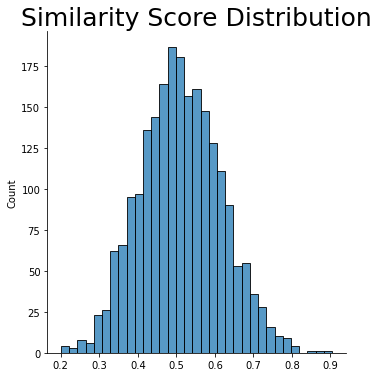

In [72]:
#below shows that there are pairs of topics which are extremely similar. Let's use 
# this as motivation for the topic reduction
fig=sns.displot(x=no_reduction_similarity_scores, kind = 'hist')
plt.title('Similarity Score Distribution', fontsize=25)
plt.savefig(results_path+'/similarity_distribution.png',bbox_inches='tight')
plt.show()



In [73]:
#by setting to auto, we reduce the number of topics iteratively as long as a pair of topics
# is found that exceeds a minimum similarity of 0.9
reduced_topics, reduced_probs = topic_model.reduce_topics(data['lem_text'], topics, probs, nr_topics='auto')

2022-03-28 20:54:16,008 - BERTopic - Reduced number of topics from 67 to 34


In [74]:
#extract the most frequent topics - observe minimal change
freq = topic_model.get_topic_info()
freq.head(10)

,Topic,Count,Name
0,-1,2670,-1_paper_policy_financial_rate
1,0,1963,0_fiscal_financial_paper_country
2,1,856,1_exchange_rate_inflation_exchange rate
3,2,246,2_tax_revenue_vat_income
4,3,215,3_wage_labor_unemployment_labor market
5,4,103,4_imf_program_country_imfsupported
6,5,94,5_housing_house_house price_price
7,6,61,6_forecast_forecasting_indicator_model
8,7,59,7_public_investment_infrastructure_public inve...
10,8,58,8_oil_oil price_price_shock


In [75]:
#get number of topics. Minus 1 because the set of topics includes (-1)
number_of_topics = len(set(reduced_topics)) - 1
number_of_topics
# we have trimmed 20 topics

33

In [76]:
#visualise topics after reduction
topic_model.visualize_topics(topics=[i for i in range(0,33)])

In [77]:
#visualise topics
vis_2=topic_model.visualize_topics(topics=[i for i in range(0,33)])
vis_2.write_html(results_path + 'reduction_intertopic.html')

In [78]:
#visualise similarity after topic_reduction
topic_model.visualize_heatmap(n_clusters=20, width=1000, height=1000)

In [79]:
#visualise terms for top topics
topic_model.visualize_barchart(top_n_topics=10,topics=[i for i in range(1,11)])
#object.write_html(figure_save_path + 'no_reduction_topic_word_scores.html')

In [80]:
# Saving HTMLs with barcharts ony shwing 10 and 20 topics
top_words_after_red_10=topic_model.visualize_barchart(top_n_topics=10,topics=[i for i in range(1,11)])
top_words_after_red_20=topic_model.visualize_barchart(top_n_topics=20,topics=[i for i in range(1,21)])

top_words_after_red_10.write_html(results_path + 'Top_Words_AR_10.html')
top_words_after_red_20.write_html(results_path + 'Top_Words_AR_20.html')

In [81]:
#Find topics most similar to a search_term
topic_model.find_topics('communist', top_n=5) 

([23, 26, 29, 27, 25],
 [0.4855084332883939,
  0.470469812970294,
  0.46065476246131287,
  0.43914060399730875,
  0.4377651240502938])

In [82]:
topic_model.get_topic(30)

[('stress', 0.12411014768108877),
 ('stress test', 0.0855151119120545),
 ('test', 0.06459127702049922),
 ('stress testing', 0.06310898061117765),
 ('testing', 0.057405302277357614),
 ('solvency', 0.031060929908701258),
 ('financial', 0.01984235299588018),
 ('liquidity', 0.01974011330192584),
 ('risk', 0.018843768706432545),
 ('insurance', 0.01768782762411114)]

## Forcing topics

In [84]:
# Forcing topics
# For running this reduction make sure to not run the similarity reduction 
ideal_topic_number = 30
reduced_topics, reduced_probs = topic_model.reduce_topics(data['lem_text'], topics, probs, nr_topics=ideal_topic_number)

In [ ]:
#see all topics and associated c-TF-IDF score after reduction
topic_model.get_topics()

In [ ]:
#extract the most frequent topics
freq = topic_model.get_topic_info()
freq.head()

In [ ]:
topic_model.get_representative_docs(18)

In [ ]:
#get number of topics. Minus 1 because the set of topics includes (-1)
number_of_topics = len(set(reduced_topics)) - 1
number_of_topics

In [ ]:
#visualise topics after reduction
topic_model.visualize_topics()

In [ ]:
#viualise topic probabilities for the same article as before reduction
print('Topic probability distribution for', data.loc[article, 'title'])
topic_model.visualize_distribution(reduced_probs[article], min_probability=0.02)

In [ ]:
#visualise terms for top topics after topic reduction
topic_model.visualize_barchart(top_n_topics=5)

In [ ]:
#visualise similarity after topic_reduction
topic_model.visualize_heatmap(n_clusters=20, width=1000, height=1000)

In [ ]:
# Save model
#topic_model.save(model_path + "BERTopic_1_reduced_50")

# Dynamic topic modelling after reduction

In [ ]:
#load reduced model
#topic_model = BERTopic.load(model_path + "BERTopic_1_reduced_50")	

In [85]:
#dynamic topic model
topics_over_time = topic_model.topics_over_time(docs=data['lem_text'], 
                                                topics=reduced_topics, 
                                                timestamps=data['publication_date'], 
                                                global_tuning=True, 
                                                evolution_tuning=True, 
                                                nr_bins=6)



6it [00:25,  4.20s/it]


In [86]:
#visualise dynamic topic model for top 20 topics
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=33)

In [87]:
#visualise dynamic topic model for top 20 topics
dynamic_vis=topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=33)
dynamic_vis.write_html(results_path + 'All_Topics_Over_Time.html')

In [88]:
#visualise dynamic topic model for top 20 topics
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=10, normalize_frequency = True)

# Robustness checks

## Topic Modeling For The Title 

In [89]:
### Cleaning the titles 
#clean and lemmatize
data['clean_title']=[cleaning(i) for i in data['title']]
data['lem_title']=[lemmatizing(i) for i in data['clean_title']]


In [103]:
#defaults defined explicitly for readability 

#option to customise count vectorizer
#vectorizer_model = CountVectorizer(ngram_range=(1,2),max_df=0.025)

topic_model_title = BERTopic(embedding_model = 'all-mpnet-base-v2', language="english", 
                       calculate_probabilities=True, verbose=True,
                       top_n_words = 10, n_gram_range = (1,2),
                       min_topic_size = 10, vectorizer_model = None)

#topic_model = BERTopic(min_topic_size=20, verbose=True)

topics_title, probs_title = topic_model_title.fit_transform(data['lem_title'].to_list())

Batches:   0%|          | 0/227 [00:00<?, ?it/s]

2022-03-28 21:16:45,024 - BERTopic - Transformed documents to Embeddings
2022-03-28 21:17:08,937 - BERTopic - Reduced dimensionality with UMAP
2022-03-28 21:17:13,629 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [104]:
# Get topics and its words
dict_topics_title=topic_model_title.get_topics()
# Saving usefull columns on the dataframe 
data['topic_title']=topics_title
data['probs_title']=[i for i in probs_title]
data['max_prob_title']=[max(i) for i in data['probs_title']]
data['count_words_title']=[get_word_count_by_document(i,j,dict_topics_title) for i,j in zip(data['lem_title'],data['topic_title'])]
data['tf_words_title']=[get_word_proportion_by_document(i,j,dict_topics_title) for i,j in zip(data['lem_title'],data['topic_title'])]
data['words_topic_title']=[[j[0] for j in dict_topics_title.get(i)] for i in data['topic_title']]

In [105]:
ideal_topic_number = 30
reduced_topics_titles, reduced_probs_title = topic_model_title.reduce_topics(data['lem_title'], topics_title, probs_title, nr_topics=ideal_topic_number)

2022-03-28 21:17:17,175 - BERTopic - Reduced number of topics from 129 to 31


In [106]:
#extract the most frequent topics
freq_title = topic_model_title.get_topic_info()
freq.head()

,Topic,Count,Name
0,-1,2670,-1_paper_policy_financial_rate
1,0,1963,0_fiscal_financial_paper_country
2,1,856,1_exchange_rate_inflation_exchange rate
3,2,246,2_tax_revenue_vat_income
4,3,215,3_wage_labor_unemployment_labor market


In [107]:
topic_model_title.get_topic(0)

[('fiscal', 0.13716940751116474),
 ('fiscal policy', 0.05490897757567081),
 ('rule', 0.03370805818006637),
 ('policy', 0.03275712139420186),
 ('fiscal consolidation', 0.03046523056685486),
 ('consolidation', 0.028733986693210693),
 ('fiscal rule', 0.02406000072075469),
 ('aging', 0.022644706560710298),
 ('fiscal transparency', 0.019464421784845972),
 ('multiplier', 0.019258273300874696)]

In [108]:
#visualise topics after reduction
topic_model_title.visualize_topics()

In [109]:
#visualise terms for top topics
topic_model_title.visualize_barchart(top_n_topics=10)

In [110]:
#visualise similarity after topic_reduction
topic_model_title.visualize_heatmap(n_clusters=20, width=1000, height=1000)

In [111]:
#dynamic topic model
topics_over_time_title = topic_model_title.topics_over_time(docs=data['lem_title'], 
                                                topics=reduced_topics_titles, 
                                                timestamps=data['publication_date'], 
                                                global_tuning=True, 
                                                evolution_tuning=True, 
                                                nr_bins=20)

20it [00:03,  6.17it/s]


In [112]:
#visualise dynamic topic model for top 20 topics
topic_model_title.visualize_topics_over_time(topics_over_time_title, top_n_topics=20)

In [113]:
data.head()

,title,authors,publication_date,summary,length,subjects,url,tokens,len_corpus,clean_text,...,words_topic,clean_title,lem_title,topic_title,probs_title,max_prob_title,count_words_title,tf_words_title,words_topic_title,max_title
0,Secular Drivers of the Natural Rate of Interes...,Josef Platzer ; Marcel Peruffo,2022-02-11,"We develop a heterogeneous agent, overlapping ...",88.0,NaN,https://www.imf.org/en/Publications/WP/Issues/...,"[We, develop, a, heterogeneous, agent, ,, over...",253,develop heterogeneous agent overlapping genera...,...,"[vote, election, political, voting, crime, ref...",secular drivers natural rate interest united s...,secular driver natural rate interest united st...,28,"[0.0025584354494756403, 0.0018199053671305674,...",0.082798,"{'interest rate': 0, 'interest': 1, 'rate': 1,...","{'interest rate': 0.0, 'interest': 0.013698630...","[interest rate, interest, rate, neutral, rate ...",0.260143
1,2020 Global Stocktaking of National Accounts S...,Anthony Silungwe ; Andrew Baer ; Vanda Guerreiro,2022-02-11,"This paper analyzes the availability, methodol...",26.0,NaN,https://www.imf.org/en/Publications/WP/Issues/...,"[This, paper, analyzes, the, availability, ,, ...",238,paper analyzes availability methodological sou...,...,"[financial, policy, paper, bank, rate, market,...",global stocktaking national accounts statistic...,global stocktaking national account statistic ...,-1,"[0.0014009739337260735, 0.0010480791739974063,...",0.005972,"{'exchange': 0, 'exchange rate': 0, 'rate': 0,...","{'exchange': 0.0, 'exchange rate': 0.0, 'rate'...","[exchange, exchange rate, rate, financial, pol...",0.354753
2,"Dollar Invoicing, Global Value Chains, and the...",David Cook ; Nikhil Patel,2022-02-11,Recent literature has highlighted that interna...,46.0,NaN,https://www.imf.org/en/Publications/WP/Issues/...,"[Recent, literature, has, highlighted, that, i...",183,recent literature highlighted international tr...,...,"[financial, policy, paper, bank, rate, market,...",dollar invoicing global value chains business ...,dollar invoicing global value chain business c...,6,"[0.00410660452513121, 0.0036919173267831408, 0...",0.259688,"{'business cycle': 1, 'business': 1, 'cycle': ...","{'business cycle': 0.01282051282051282, 'busin...","[business cycle, business, cycle, internationa...",0.096966
3,Falling Use of Cash and Demand for Retail Cent...,Tanai Khiaonarong ; David Humphrey,2022-02-04,Cash use in most countries is falling slowly. ...,25.0,NaN,https://www.imf.org/en/Publications/WP/Issues/...,"[Cash, use, in, most, countries, is, falling, ...",113,cash use countries falling slowly margin young...,...,"[money, money demand, demand, cash, cash use, ...",falling use cash demand retail central bank di...,falling use cash demand retail central bank di...,-1,"[0.004994398429826074, 0.003649351447267177, 0...",0.049337,"{'exchange': 0, 'exchange rate': 0, 'rate': 0,...","{'exchange': 0.0, 'exchange rate': 0.0, 'rate'...","[exchange, exchange rate, rate, financial, pol...",0.402544
4,Gendered Taxes: The Interaction of Tax Policy ...,Maria Delgado Coelho ; Aieshwarya Davis ; Alex...,2022-02-04,This paper provides an overview of the relatio...,53.0,NaN,https://www.imf.org/en/Publications/WP/Issues/...,"[This, paper, provides, an, overview, of, the,...",158,paper provides overview relation tax policy ge...,...,"[gender, woman, female, budgeting, gender budg...",gendered taxes interaction tax policy gender e...,gendered tax interaction tax policy gender equ...,82,"[0.0013445199326295014, 0.001939080894473632, ...",0.191905,"{'gender': 2, 'gender budgeting': 0, 'budgetin...","{'gender': 0.0392156862745098, 'gender budgeti...","[gender, gender budgeting, budgeting, survey g...",0.740541


## BERT for the Subjects

In [114]:
### Dealing With Topics 
data['lem_subjects']=[np.nan if i!=i else lemmatizing(i) for i in data['subjects']]
data['lem_subjects']=data['lem_subjects'].fillna('')

In [115]:
# The problem is that if we split by capital letter we are going to end up with different topics for words as United States
# So we want a dictionary of most the common biagrams with the first letter of the first term and second term being Uppercase, so we dont split that words
subs=(' '.join(data['lem_subjects']))
tokens = word_tokenize(subs)
bi_grams = list(ngrams(tokens, 2))
counter = Counter(bi_grams)
most_common_counter = counter.most_common()

In [116]:
# We only keep the biagrams who met the condition 
first_word=[]
second_word=[]
number_of_counts=[]
for i in most_common_counter:
    if (i[0][0][0].isupper()) and (i[0][1][0].isupper()):
        first_word.append(i[0][0])
        second_word.append(i[0][1])
        number_of_counts.append(i[1])
non_split=pd.DataFrame()
non_split['first_word']=first_word
non_split['second_word']=second_word
non_split['counts']=number_of_counts

In [117]:
non_split.head()

,first_word,second_word,counts
0,United,States,310
1,Sub-Saharan,Africa,118
2,Inflation,Monetary,99
3,Central,Banks,90
4,Latin,America,88


In [121]:
### Read the biagrams with the problem
bigrams_clean = pd.read_csv(path + '/bigrams_subjects.csv')
bigrams_clean['third_word'] = bigrams_clean['third_word'].fillna('')

bigrams_clean = [(i + ' ' + j + ' ' + k).rstrip() for i, j, k in zip(list(bigrams_clean.first_word), list(bigrams_clean.second_word), list(bigrams_clean.third_word))]

In [122]:
# Now split the subjects themselves into a list, but only where there is a word with a uppercase letter followed by a lowercase one 
def split_by_title_word(s):
    return [chunk for chunk in re.split(r"([A-Z][a-z][^A-Z]*)", s) if chunk]

subjects_split = data['lem_subjects'].apply(lambda x: split_by_title_word(x))

subjects_split = [[j.rstrip() for j in i] for i in subjects_split]

In [123]:
# This function takes a candidate list (our custom bigrams) and checks whether each word in them appears in a longer list (our subjects) 
# If there is a match, then it replaces each of the individual words in the longer list with the bigram
# E.g. in ["United", "States", "Richard is awesome"] it will take a bigram ["United States"] and return ["United States", "United States", "Richard is awesome"]   
def replace_matches(longer_list, subset_candidates):
    for j in subset_candidates:
        ind_words = j.split()
        if set(ind_words).issubset(longer_list):
            replacements = [i in set(ind_words) for i in longer_list]
            for i in range(0, len(replacements)):
                if replacements[i]:
                    longer_list[i] = j
    return(longer_list)

# Now subjects split has our cleaned subject data
for i in subjects_split:
   i = set(replace_matches(i, bigrams_clean))   

In [124]:
# put the subject in strings, since bert recibe a list of strings
lem_subjects_s=[]
for i in subjects_split:
  lem_subjects_s.append(' '.join(i))

In [125]:
data['lem_subjects']=lem_subjects_s

In [157]:
### Just keep the documents that have subjects
data_sub=data[data['lem_subjects']!=''].reset_index()

In [158]:
#defaults defined explicitly for readability 
topic_model_subjects = BERTopic(embedding_model = 'all-mpnet-base-v2', language="english", 
                       calculate_probabilities=True, verbose=True,
                       top_n_words = 10, n_gram_range = (1,2),
                       min_topic_size = 10, vectorizer_model = None)

#topic_model = BERTopic(min_topic_size=20, verbose=True)

topics_subjects, probs_subjects = topic_model_subjects.fit_transform(data_sub['lem_subjects'].to_list())

Batches:   0%|          | 0/204 [00:00<?, ?it/s]

2022-03-28 21:33:05,456 - BERTopic - Transformed documents to Embeddings
2022-03-28 21:33:26,676 - BERTopic - Reduced dimensionality with UMAP
2022-03-28 21:33:31,828 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [159]:
# Get topics and its words
dict_topics_subjects=topic_model_subjects.get_topics()
# Saving usefull columns on the dataframe 
data_sub['topic_subjects']=topics_subjects
data_sub['probs_subjects']=[i for i in probs_subjects]
data_sub['max_prob_subjects']=[max(i) for i in data_sub['probs_subjects']]
data_sub['count_words_subjects']=[get_word_count_by_document(i,j,dict_topics_subjects) for i,j in zip(data_sub['lem_subjects'],data_sub['topic_subjects'])]
data_sub['tf_words_subjects']=[get_word_proportion_by_document(i,j,dict_topics_subjects) for i,j in zip(data_sub['lem_subjects'],data_sub['topic_subjects'])]
data_sub['words_topic_subjects']=[[j[0] for j in dict_topics_subjects.get(i)] for i in data_sub['topic_subjects']]
data_sub=data_sub[['lem_subjects','publication_date','title','topic_subjects','probs_subjects','max_prob_subjects','count_words_subjects','tf_words_subjects','words_topic_subjects']]

In [160]:
ideal_topic_number = 30
reduced_topics_subjects, reduced_probs_subjects = topic_model_subjects.reduce_topics(data_sub['lem_subjects'], topics_subjects, probs_subjects, nr_topics=ideal_topic_number)

2022-03-28 21:33:35,334 - BERTopic - Reduced number of topics from 142 to 31


In [161]:
#extract the most frequent topics
freq_subjects = topic_model_subjects.get_topic_info()
freq_subjects.head()

,Topic,Count,Name
0,-1,3063,-1_financial_economic_policy_crisis
1,0,366,0_fiscal_fiscal policy_government_public
2,1,220,1_tax_revenue_tax revenue_tax policy
3,2,157,2_investment_market_international_capital market
4,3,149,3_capital_capital flow_flow_foreign


In [162]:
topic_model_subjects.get_topic(0)

[('fiscal', 0.09237042810361704),
 ('fiscal policy', 0.05725500809019866),
 ('government', 0.04790254986106914),
 ('public', 0.046772782067968144),
 ('expenditure', 0.04108746275889607),
 ('policy', 0.040050267037083906),
 ('policy fiscal', 0.034100008546692914),
 ('debt', 0.0326404738021832),
 ('fiscal consolidation', 0.030519980086916986),
 ('government expenditure', 0.030501903912348194)]

In [163]:
#visualise topics after reduction
topic_model_subjects.visualize_topics()

In [164]:
#visualise terms for top topics
topic_model_subjects.visualize_barchart(top_n_topics=10)

In [165]:
#visualise similarity after topic_reduction
topic_model_subjects.visualize_heatmap(n_clusters=20, width=1000, height=1000)

In [166]:
#dynamic topic model
topics_over_time_subjects = topic_model_subjects.topics_over_time(docs=data_sub['lem_subjects'], 
                                                topics=reduced_topics_subjects, 
                                                timestamps=data_sub['publication_date'], 
                                                global_tuning=True, 
                                                evolution_tuning=True, 
                                                nr_bins=20)

20it [00:01, 11.12it/s]


In [167]:
#visualise dynamic topic model for top 20 topics
topic_model_subjects.visualize_topics_over_time(topics_over_time_subjects, top_n_topics=20)

In [168]:
# Join the first dataframe with the subjects one
data_sub=data_sub.drop(['lem_subjects','publication_date'],axis=1)
data=data.merge(data_sub,on=['title'],how='left')

In [170]:
data.tail()

,title,authors,publication_date,summary,length,subjects,url,tokens,len_corpus,clean_text,...,tf_words_title,words_topic_title,max_title,lem_subjects,topic_subjects,probs_subjects,max_prob_subjects,count_words_subjects,tf_words_subjects,words_topic_subjects
7244,The Identification of the Causes of Business C...,Don E. Schlagenhauf ; Stefan C. Norrbin,1990-01-01,Empirical research has been conducted on the v...,26.0,Business cycles,https://www.imf.org/en/Publications/WP/Issues/...,"[Empirical, research, has, been, conducted, on...",101,empirical research conducted various theories ...,...,"{'business cycle': 0.02, 'business': 0.02, 'cy...","[business cycle, business, cycle, internationa...",1.000000,Business cycle,82.0,"[1.93615160572218e-307, 1.4041700194973e-307, ...",1.000000,"{'cycle business': 0, 'business cycle': 0, 'bu...","{'cycle business': 0.0, 'business cycle': 0.0,...","[cycle business, business cycle, business, cyc..."
7245,Financial Market Integration and Exchange Rate...,Liliana Rojas-Suárez ; Donald J Mathieson,1990-01-01,This paper examines how a country’s exchange r...,66.0,Capital markets Exchange rate policy Internati...,https://www.imf.org/en/Publications/WP/Issues/...,"[This, paper, examines, how, a, country, ’, s,...",105,paper examines country exchange rate policy ad...,...,"{'exchange': 0.02040816326530612, 'exchange ra...","[exchange, exchange rate, rate, financial, pol...",0.298211,Capital market Exchange rate policy Internatio...,-1.0,"[0.0010222300955838365, 0.0006950694776794514,...",0.018522,"{'financial': 0, 'crisis': 0, 'market': 2, 'ex...","{'financial': 0.0, 'crisis': 0.0, 'market': 0....","[financial, crisis, market, exchange, rate, po..."
7246,The Impact of Macroeconomic Policieson the Lev...,Vito Tanzi,1988-10-24,In recent years the level of taxation of many ...,28.0,Developing countries Tax policy Tax reforms Ta...,https://www.imf.org/en/Publications/WP/Issues/...,"[In, recent, years, the, level, of, taxation, ...",136,recent years level taxation many developing co...,...,"{'exchange': 0.0, 'exchange rate': 0.0, 'rate'...","[exchange, exchange rate, rate, financial, pol...",1.000000,Developing country Tax policy Tax reform Tax r...,1.0,"[0.008769512358326815, 0.5635209197984097, 0.0...",0.563521,"{'tax': 0, 'tax revenue': 0, 'revenue': 1, 'in...","{'tax': 0.0, 'tax revenue': 0.0, 'revenue': 0....","[tax, tax revenue, revenue, income tax, tax re..."
7247,"Presumptive Income Taxation : Administrative, ...",Milka Casanegra de Jantscher ; Vito Tanzi,1987-08-01,This paper discusses assessment of income on t...,21.0,Income taxes Tax administration Taxation,https://www.imf.org/en/Publications/WP/Issues/...,"[This, paper, discusses, assessment, of, incom...",82,paper discusses assessment income basis approx...,...,"{'tax': 0.014925373134328358, 'taxation': 0.01...","[tax, taxation, vat, tax policy, income tax, i...",0.551334,Income tax Tax administration Taxation,1.0,"[0.012255115543485504, 0.2505140271524236, 0.0...",0.250514,"{'tax': 1, 'tax revenue': 0, 'revenue': 0, 'in...","{'tax': 0.02631578947368421, 'tax revenue': 0....","[tax, tax revenue, revenue, income tax, tax re..."
7248,Fiscal Policy and Private Sector Saving Behavi...,International Monetary Fund,1987-07-01,Tax or debt financing of a given rate of gover...,24.0,Budget deficits Consumption Deficit financing ...,https://www.imf.org/en/Publications/WP/Issues/...,"[Tax, or, debt, financing, of, a, given, rate,...",84,tax debt financing given rate government expen...,...,"{'exchange': 0.0, 'exchange rate': 0.0, 'rate'...","[exchange, exchange rate, rate, financial, pol...",0.240174,Budget deficit Consumption Deficit financing D...,0.0,"[0.17245720416890764, 0.008841328248624875, 0....",0.172457,"{'fiscal': 0, 'government': 0, 'fiscal policy'...","{'fiscal': 0.0, 'government': 0.0, 'fiscal pol...","[fiscal, government, fiscal policy, expenditur..."


In [171]:
# Export final dataset 
data.to_csv(path+'data_final.csv',index=False,sep='|',quotechar='"')